# 门控循环单元（GRU）
我们可能会遇到这样的情况：

1. **早期观测值对预测所有未来观测值具有非常重要的意义**。 考虑一个极端情况，其中第一个观测值包含一个校验和， 目标是在序列的末尾辨别校验和是否正确。 在这种情况下，第一个词元的影响至关重要。 我们希望有某些机制能够在一个记忆元里存储重要的早期信息。 如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度， 因为它会影响所有后续的观测值。

2. **一些词元没有相关的观测值**。 例如，在对网页内容进行情感分析时， 可能有一些辅助HTML代码与网页传达的情绪无关。 我们希望有一些机制来跳过隐状态表示中的此类词元。

3. **序列的各个部分之间存在逻辑中断**。 例如，书的章节之间可能会有过渡存在， 或者证券的熊市和牛市之间可能会有过渡存在。 在这种情况下，最好有一种方法来*重置*我们的内部状态表示。

其中最早的方法是”长短期记忆”（`long-short-term memory，LSTM`） (Hochreiter and Schmidhuber, 1997)， 我们将在 9.2节中讨论。 门控循环单元（`gated recurrent unit，GRU`） (Cho et al., 2014) 是一个稍微简化的变体，通常能够提供同等的效果， 并且计算 (Chung et al., 2014)的速度明显更快。 由于门控循环单元更简单，我们从它开始解读。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import sys
sys.path.append("../")
from MyUtils import d2laiUtils as d2l

## 重置门（reset gate）和更新门（Update Gate）
图9.1.1 描述了门控循环单元中的重置门和更新门的输入， 输入是由当前时间步的输入和前一时间步的隐状态给出。 两个门的输出是由使用sigmoid激活函数的两个全连接层给出。

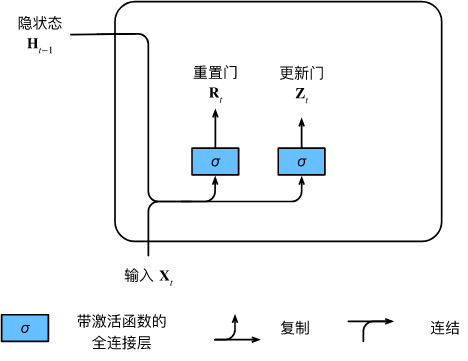

其计算公式如下:  
$$
\begin{split}\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}\end{split}
$$  
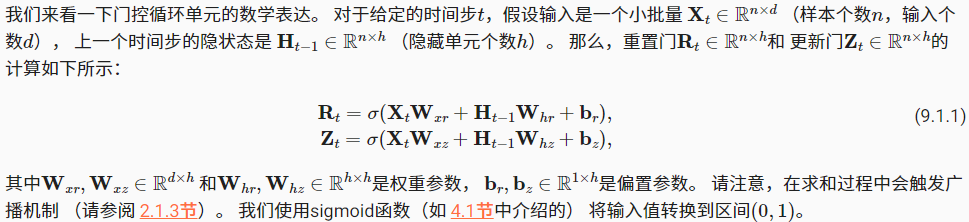  
## 候选隐状态(candidate hidden state)
$$
\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),
$$

与 (8.4.5)相比， (9.1.2)中的$\mathbf{R}_t$和$\mathbf{H}_{t-1}$ 的元素相乘可以减少以往状态的影响。 每当重置门中$\mathbf{R}_t$的项接近1时， 我们恢复一个如 (8.4.5)中的普通的循环神经网络。 对于**重置门$\mathbf{R}_t$中所有接近0的项， 候选隐状态是以作为输入的多层感知机的结果。 因此，任何预先存在的隐状态都会被重置为默认值**。

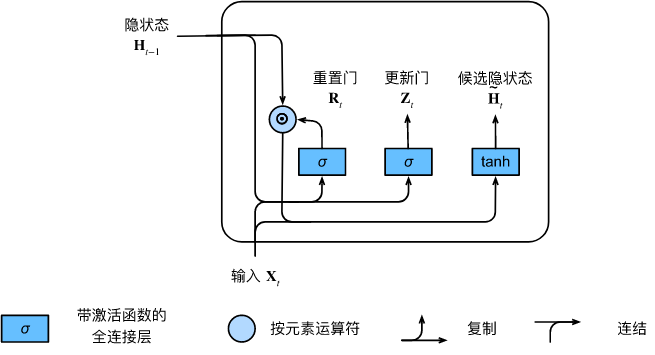

## 隐状态更新
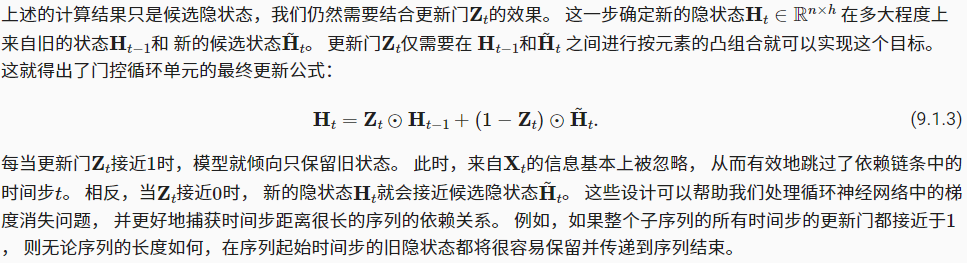
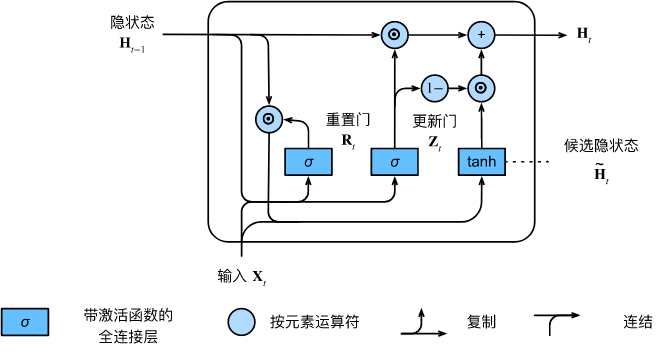

* 总结，重置门有助于记住短期信息
* 更新门有助于记住长期信息

In [2]:
def gru_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    def para():
        return (normal((num_inputs, num_hiddens)),
               normal((num_hiddens, num_hiddens)),
               torch.zeros(num_hiddens, device=device))
    # 重置门 更新门 参数
    W_xr, W_hr, br = para()
    W_xz, W_hz, bz = para()
    # 候选状态门 参数
    W_xh, W_hh, bh = para()
    # 输出层（全连接）
    W_hq, bq = normal((num_hiddens, num_outputs)), torch.zeros(num_outputs, device=device)
    params = [W_xr, W_hr, br, W_xz, W_hz, bz, W_xh, W_hh, bh, W_hq, bq]
    for p in params:
        p.requires_grad_(True)
    return params

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.randn((batch_size, num_hiddens), device=device),)

def gru_model(inputs, state, params):
    """inputs: (time_steps, batch_size, num_inputs), state(batch_size, num_hiddens)"""
    W_xr, W_hr, br, W_xz, W_hz, bz, W_xh, W_hh, bh, W_hq, bq= params
    H, = state
    outputs = []
    for X in inputs: # step by step update the state
        # X(n, d)
        R = torch.sigmoid(X@W_xr+H@W_hr+br)
        Z = torch.sigmoid(X@W_xz+H@W_hz+bz)
        cH = torch.tanh(X@W_xh+(torch.multiply(R, H))@W_hh+bh)
        H = torch.multiply(Z, H) + torch.multiply(1-Z, cH)  # new_state
        Y = H@W_hq + bq  # Y--(batch_size, num_outputs)
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, )


困惑度 3.8, 18655.9 词元/秒 cuda:0
time traveller project gutenberg tm works in the starting up and
traveller and the starting up and struck my hand and the st


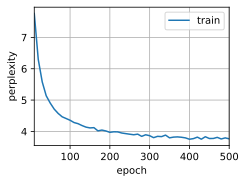

In [4]:
batch_size, num_steps = 36, 24
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps, True, -1)
num_hiddens, vocab_size, device = 128, len(vocab), torch.device("cuda:0")
lr, num_epochs, use_random = 1, 500, True
gru = d2l.RNNModelScratch(vocab_size, num_hiddens, device, gru_params, init_gru_state, gru_model)
d2l.train_ch8(gru, train_iter, vocab, lr, num_epochs, device, use_random)

困惑度 2.9, 343245.5 词元/秒 cuda:0
time traveller and the spoke of a broad river valley but the tim
traveller and the spoke of a broad river valley but the tim


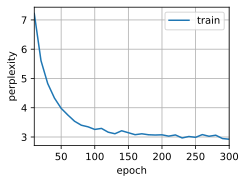

In [8]:
batch_size, num_steps = 64, 32
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps, True, -1)
num_hiddens, vocab_size, device = 256, len(vocab), torch.device("cuda:0")
lr, num_epochs, use_random = 2.5, 300, True
gru_layer = nn.GRU(vocab_size, num_hiddens)
model = d2l.RNNModel(gru_layer, vocab_size)
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [13]:
d2l.predict_ch8("i love you", 50, gru, vocab, device)

'i love you was a reflected and particularly in the starting '

In [15]:
d2l.predict_ch8("i love you", 150, model, vocab, device)

'i love you may use this ebook for nearly and the spoke of a broad rish i was put the million dial was a little down into the sun at was still pull palace of gre'